## Markov Network

A Markov network is a set of random variables having a Markov property described by an undirected graph.

**Markov property**: Any two subsets of variables are conditionally independent given a separating subset.

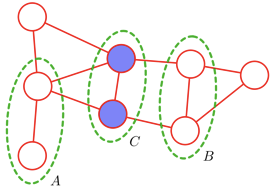

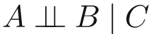

**Clique factorization:**
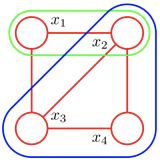

Let $C$ denote a clique and the set of variables in it as ${\bf x}_C$
$$p({\bf x})=\frac{1}{Z}\prod_C \psi_C({\bf x}_C)$$
where $\psi_C({\bf x}_C)$ is called potential function and $Z$ is the normalization factor.

The definition is equivalent if only maximal cliques are used.

Boltzmann distribution:
$$\psi_C({\bf x}_C)=\exp\{-E({\bf x}_C)\}$$
where $E({\bf x}_C)$ is called energy function.
$$p({\bf x})=\frac{1}{Z}\prod_C \psi_C({\bf x}_C)=\frac{1}{Z}\exp\{-\sum_C E({\bf x}_C)\}$$

## Image Denoising

**Problem Description**:

Suppose we have an image consisting of a 2-dimensional array of pixels, where each pixel value is binary. Assume it got corrupted by random noise, where each pixel in the image is flipped with 10% probability.
Our goal is to recover the original image.

In [1]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

Image:


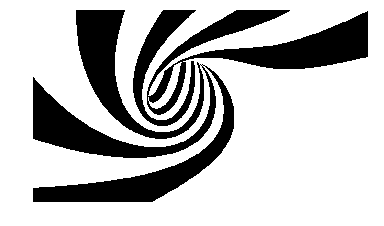

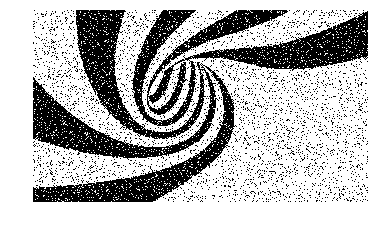

In [2]:
orig_img = np.array(mpimg.imread('../input/origimg.jpg')).astype(int)
orig_img[orig_img<128] = -1
orig_img[orig_img>=128] = 1

plt.figure()
plt.axis('off')
plt.imshow(orig_img, cmap='binary_r')

noisy_img = np.array(mpimg.imread('../input/noisyimg.jpg')).astype(int)
noisy_img[noisy_img<128] = -1
noisy_img[noisy_img>=128] = 1

plt.figure()
plt.axis('off')
plt.imshow(noisy_img, cmap='binary_r')
print ('Image:')


### Model

**Observed variables**: each pixel in the noisy image, $y_{ij}\in \{-1,+1\}$

**Unobserved variables**: each pixel in the ground truth image, $x_{ij}\in \{-1,+1\}$

**Assumptions**:

1. There is a strong correlation between $x_{ij}$ and $y_{ij}$

2. There is a strong correlation between neighboring pixels, i.e., $x_{ij}$ and $x_{i+1,j}$, $x_{i-1,j}$, $x_{i,j+1}$, $x_{i,j-1}$

Energy function:
$$E({\bf x},{\bf y})=-\beta\sum_{i,j}x_{ij}y_{ij}-\eta\sum_{\{ij,kl\}}x_{ij}x_{kl}$$
where (i,j) and (k,l) in the third term are adjacent pixels.

\begin{equation}
\begin{split}
\arg\max_{\bf x} p({\bf x}|{\bf y})&=\arg\max_{\bf x} p({\bf x},{\bf y})\\
&=\arg\max_{\bf x} \frac{1}{Z}\exp\{-E({\bf x},{\bf y})\}\\
&=\arg\min_{\bf x} E({\bf x},{\bf y})\\
&= \arg\min_{\bf x} -\beta\sum_{i,j}x_{ij}y_{ij}-\eta\sum_{\{ij,kl\}}x_{ij}x_{kl}\\
&= \arg\max_{\bf x} \beta\sum_{i,j}x_{ij}y_{ij}+\eta\sum_{\{ij,kl\}}x_{ij}x_{kl}
\end{split}
\end{equation}

####  Iterated Conditional Modes (ICM) 
1. Initialize $x_{ij}$ to their noisy values $y_{ij}$.

2. Iterate through each $x_{ij}$ and check whether setting it’s value to +1 or -1 leads to a lower energy (higher probability).

In [3]:
# compute the error rate between the noisy image and the original image
def compute_error_rate(img1, img2):
    err = abs(img1 - img2) / 2
    return np.sum(err) / np.size(img2) * 100

print ('Percentage of mismatched pixels in noisy image: %.6f%%' % compute_error_rate(orig_img, noisy_img))

Percentage of mismatched pixels in noisy image: 9.938571%


In [4]:
def compute_prob(X, Y, i, j, m, n, beta, eta, x_value):
    
    result = beta * Y[i][j] * x_value
    
    if i > 0:
        result += eta * x_value * X[i-1][j]
    if i < m-1:
        result += eta * x_value * X[i+1][j]
    if j > 0:
        result += eta * x_value * X[i][j-1]
    if j < n-1:
        result += eta * x_value * X[i][j+1]
    
    
    return result

In [5]:
def denoise_image(Y, orig, beta, eta):
    m, n = np.shape(Y)
    X = np.copy(Y)
    max_iter = 5
    
    for k in range(max_iter):
        for i in range(m):
            for j in range(n):
                
                p_pos = compute_prob(X, Y, i, j, m, n, beta, eta, 1)
                p_neg = compute_prob(X, Y, i, j, m, n, beta, eta, -1)
                
                if p_pos > p_neg:
                    X[i][j] = 1
                else:
                    X[i][j] = -1
                    
        print('Iteration number:', k+1)
        print ('Percentage of mismatched pixels: %.6f%%' % compute_error_rate(orig, X))
    return X

Iteration number: 1
Percentage of mismatched pixels: 0.563214%
Iteration number: 2
Percentage of mismatched pixels: 0.407143%
Iteration number: 3
Percentage of mismatched pixels: 0.399286%
Iteration number: 4
Percentage of mismatched pixels: 0.397857%
Iteration number: 5
Percentage of mismatched pixels: 0.397500%
Percentage of mismatched pixels in denoised image: 0.397500%
Denoised Image:


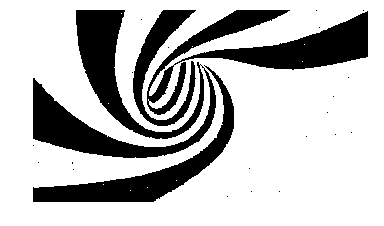

In [6]:
beta = 1.0
eta = 2.1
denoised_img = denoise_image(noisy_img, orig_img, beta, eta)

plt.figure()
plt.axis('off')
plt.imshow(denoised_img, cmap='binary_r')
print ('Percentage of mismatched pixels in denoised image: %.6f%%' % compute_error_rate(orig_img, denoised_img))
print ('Denoised Image:')